In [1]:
! wget https://cdn.britannica.com/86/166986-050-4CEFE5DE/cute-kitten-and-puppy-outdoors-in-grass.jpg -O image1.jpg

--2024-09-09 10:38:36--  https://cdn.britannica.com/86/166986-050-4CEFE5DE/cute-kitten-and-puppy-outdoors-in-grass.jpg
cdn.britannica.com (cdn.britannica.com) 해석 중... 18.64.8.32, 18.64.8.82, 18.64.8.44, ...
다음으로 연결 중: cdn.britannica.com (cdn.britannica.com)|18.64.8.32|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 56749 (55K) [image/jpeg]
저장 위치: `image1.jpg'

image1.jpg          100%[===================>]  55.42K  --.-KB/s    /  0.01s   

2024-09-09 10:38:36 (3.85 MB/s) - `image1.jpg' 저장함 [56749/56749]



# Object detection

## 1. Bounding box

객체 탐지는 이미지 내 여러 객체의 클래스와 위치를 찾는 기술입니다. 객체 탐지에서는 일반적으로 객체의 공간 위치를 설명하기 위해 Bounding box(경계 상자)를 사용합니다. 경계 상자는 직사각형이며, 네 가지 값을 이용하여 그 위치를 표현합니다.

In [3]:
import cv2
import matplotlib.pyplot as plt

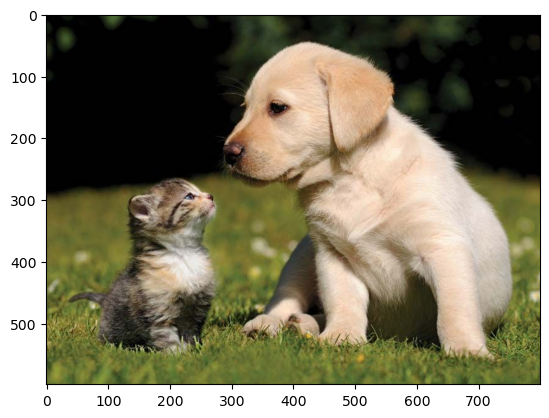

In [4]:
image_path = "/kaggle/working/image1.jpg"

image = cv2.imread("image1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### x1y1x2y2
- 상자의 대각선 방향 두 꼭짓점을 이용
- 좌상단(top left)과 우하단(bottom right)를 지정

In [11]:
# draw a bounding box with the image
def draw_bbox(top_left, bottom_right, image, color, line_thickness=2):
    new_image = image.copy()
    cv2.rectangle(new_image, top_left, bottom_right, color, line_thickness)
    return new_image

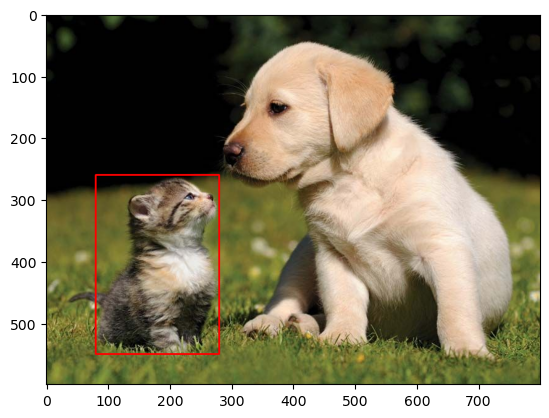

In [16]:
# 고양이 주변에 붉은 박스 그리기
n_img = draw_bbox((80, 260), (280, 550), image, (255, 0, 0), 2)
plt.imshow(n_img)


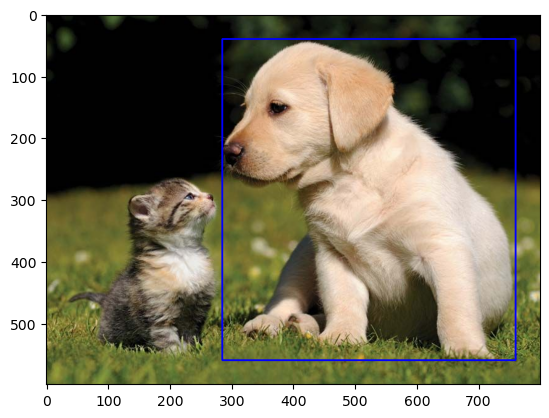

In [26]:
# 강아지 주변에 파란 박스 그리기
n_img = draw_bbox((285, 40), (760, 560), image, (0, 0, 255), 2)
plt.imshow(n_img)

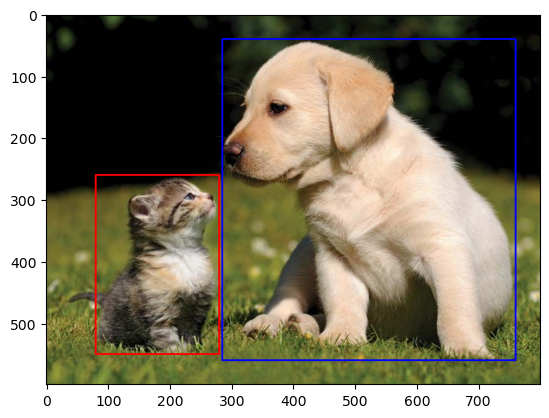

In [27]:
# 둘 다 모두 표시

nn_img = draw_bbox((80, 260), (280, 550), n_img, (255, 0, 0), 2)
plt.imshow(nn_img)

### xywh

- 상자의 좌상단 좌표와 너비, 높이를 이용하여 바운딩 박스를 정의
- 상자의 좌상단 좌표`(x, y)`
- 상자의 너비 `w`
- 상자의 높이 `h`

In [50]:
def draw_bbox_xwyh(image, top_left, width, height, color, line_thickness=2):
	new_image = image.copy()
	x, y = top_left
	bottom_right = (x+width, y+height)
	
	cv2.rectangle(new_image, top_left, bottom_right, color, line_thickness)
	return new_image

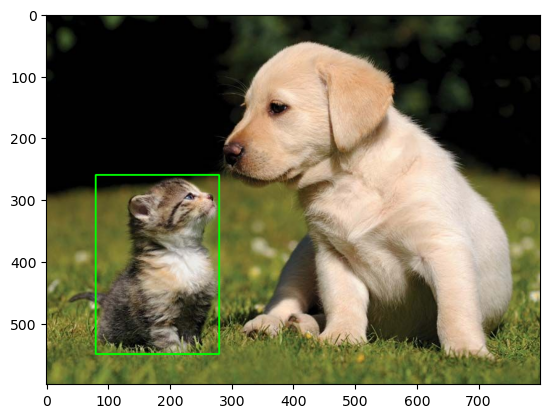

In [51]:
#고양이 주변에 녹색 박스 그리기

n_img = draw_bbox_xwyh(image, (80, 260), 200, 290, (0, 255, 0), 2)
plt.imshow(n_img)

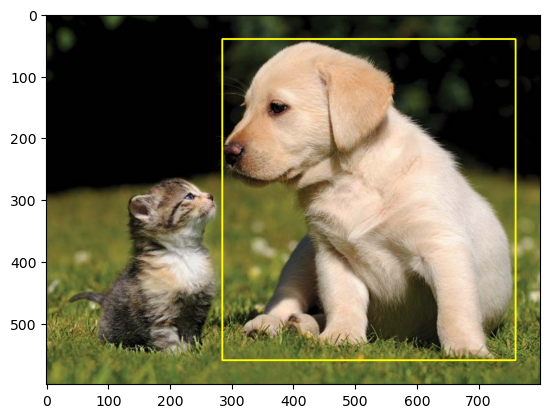

In [53]:
# 강아지 주변에 노란 박스 그리기

n_img = draw_bbox_xwyh(image, (285, 40), 475, 520, (255, 255, 0), 2)
plt.imshow(n_img)

### Polygon

- 직사각형이 아닌 다양한 형태의 바운딩 박스를 표현할 수 있는 방식

- 여러 개의 꼭짓점 좌표를 이용해 불규칙한 모양을 정의할 수 있음

- 보통 객체의 경계가 복잡하거나 직사각형으로 표현하기 힘든 경우에 사용

In [54]:
import numpy as np

def draw_polygon(points, image, color, line_thickness=2):
    new_image = image.copy()
    
    # 점들의 좌표 배열을 np.array로 변환
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 1, 2))  # 필요한 형태로 reshape
    
    # 폴리곤 그리기
    cv2.polylines(new_image, [pts], isClosed=True, color=color, thickness=line_thickness)
    return new_image

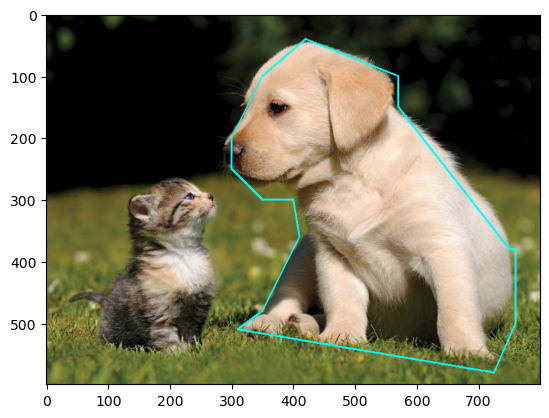

In [55]:
# 다각형의 각 좌표 (points 리스트로 입력)
polygon_points = [(420, 40), (350, 100), (300, 200), 
                  (300, 250), (350, 300), (400, 300), 
                  (410, 360), (350, 480), (310, 510),
                  (725, 580), (760, 500), (760, 380),
                  (750, 380), (570, 150), (570, 100),
                 ]
polygon_box = draw_polygon(polygon_points, image, (0, 255, 255))  # 노란색 폴리곤
plt.imshow(polygon_box)


### cwyh normalized
- 바운딩 박스를 중심 좌표 (cx, cy)와 너비 및 높이 (w, h)로 표현

- normalized는 이미지 크기와 상관없이 좌표와 크기가 0과 1 사이의 값으로 정규화된 것을 의미. 즉, 좌표와 크기는 이미지의 크기에 비례

- 이미지 크기가 달라져도 동일한 비율로 바운딩 박스를 유지할 수 있는 장점

- YOLO에서 사용

In [59]:
image.shape[:2]

(599, 800)

In [60]:
def draw_bbox_cywh_normalized(cx, cy, width, height, image, color, line_thickness=2):
	new_image = image.copy()
	img_height, img_width = image.shape[:2]
	
	top_left = int((cx - width / 2) * img_width), int((cy - height / 2) * img_height)
	bottom_right = int((cx + width / 2) * img_width), int((cy + height / 2) * img_height)

	# 바운딩 박스 그리기
	cv2.rectangle(new_image, top_left, bottom_right, color, line_thickness)
	return new_image

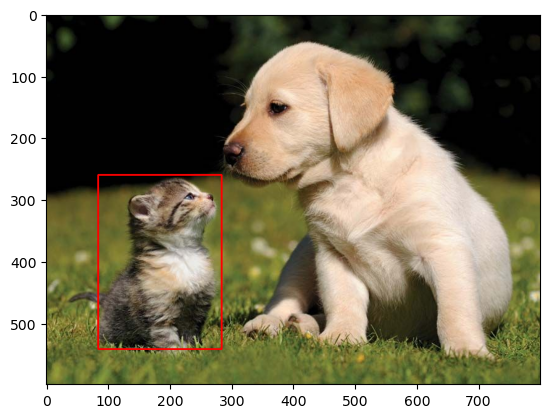

In [77]:
# 고양이 주변에 붉은 박스 그리기

n_img = draw_bbox_cywh_normalized(0.23, 0.67, 0.25, 0.47, image, (255, 0, 0), 2)
plt.imshow(n_img)

In [ ]:
# 강아지 주변에 파란 박스 그리기

## 2. Anchor box

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FZaxPg%2FbtqQIaSDb3s%2FwfOr4FA6CxKGCgTDMkmkRk%2Fimg.jpg)

- 이미지에서 객체를 찾고, 이에 들어맞는 바운딩 박스를 찾는 과정은 매우 어려움
- 대량의 영역을 샘플링하고, 이 영역들에 관심을 가질만 한 객체를 포함하는지 판단하는 과정이 필요
- 특정 픽셀에 대하여 다양한 크기의 바운딩 박스를 준비하는 과정이 앵커 박스(Anchor box)
    - 사전 정의된 프리셋

In [ ]:
def draw_anchor_boxes(anchor_boxes, cx, cy, image, colors, line_thickness=2):
    new_image = image.copy()
    img_height, img_width = image.shape[:2]
    
    # anchor_boxes의 값을 순회하며 모든 조합 별 bbox 그리기
    for 
        
    return new_image

In [ ]:
# 예시 앵커 박스들 (정규화된 width, height의 리스트)
anchor_boxes = [(0.1, 0.1), (0.2, 0.3), (0.4, 0.2), (0.5, 0.5)]

# 각 앵커 박스를 다른 색상으로 지정
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

anchor_box = draw_anchor_boxes(anchor_boxes, 0.3, 0.5, image, colors)

plt.imshow(anchor_box)

## 3. IoU(Intersection over Union)

두 bbox A와 B가 있을 때, 두 사각형이 겹치는 면적을 구하고, 이 값을 두 사각형의 합집합 면적으로 나눈 값을 IoU라고 합니다. IoU는 객체 검출(Object Detection)에서 예측된 객체와 실제 객체의 겹치는 정도를 평가할 때 사용됩니다.

In [ ]:
def calculate_iou(box1, box2):
    """
    box1과 box2는 각각 [x_min, y_min, x_max, y_max] 형식의 바운딩 박스 좌표입니다.
    """
    # 교차 영역의 좌표
    # Your code
    
    # 교차 영역의 넓이 계산 (교차 영역이 없을 경우 0)
    # Your code
    
    # 각 바운딩 박스의 넓이 계산
    # Your code
    
    # 합집합의 넓이 계산
    # Your code
    
    # IoU 계산
    # Your code
    
    return iou


## 4. NMS(Non Maximum Suppression)

- 이미지 내 객체를 탐지하기 위하여 수많은 Bounding box가 생성됨
- 그러나 이 중 객체를 잘 포함하는 박스의 수는 적음
- Confidence score가 일정 기준치 아래로 유사하지 않은 박스들은 아예 학습시키지 않음
- 또한 중복되는 박스들을 제거하는 과정도 포함


In [ ]:
# 바운딩 박스와 그 신뢰도 점수들 (박스: [x, y, w, h])
boxes = [(100, 100, 50, 80), (105, 105, 50, 80), (200, 200, 60, 90)]
confidences = [0.9, 0.85, 0.75]

# NMS 적용 (IoU 임계값: 0.5, confidence 임계값: 0.4)
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.4, nms_threshold=0.5)

# 남은 박스 출력
if len(indices) > 0:
    for i in indices:
        # indices가 2차원 배열이 아닐 때 바로 i를 사용
        box = boxes[i]
        print(f"남은 바운딩 박스: {box}")
else:
    print("남은 바운딩 박스가 없습니다.")